If on google collab, if not skip the following cell



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/TFG_Matematicas'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/TFG_Matematicas


## EDA

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import random
from utils.utils import *

## Loading the data

In [3]:
data_indexes = [(i+1,j+1) for i in range(5) for j in range(2000)]

In [4]:
identify_nan = False #Set to true to generate a file of discarded indexes containing unstable solutions
idx_discard = set()

if identify_nan:
    #Identify data with NaN and big values to discard them
    for idx in data_indexes:
        print(idx)
        mat = np.loadtxt(f'./datos_tfg/datos_tfg/tfg_datos_{idx[0]}_{idx[1]}.txt')
        if np.isnan(mat[-1]).any() or (mat[-1] > 2).any():
            idx_discard.add(idx)

    #Save de indexes
    with open('utils/idx_nan.txt', 'w') as f:
        for idx in idx_discard:
            f.write(f"{idx[0]}, {idx[1]}\n")


with open('./utils/idx_nan.txt', 'r') as f:
    for line in f:
        idx = line.strip().split(',')
        idx_discard.add((int(idx[0]), int(idx[1].strip())))

In [5]:
parameters = load_parameter_list()

In [6]:
df_parameters = pd.DataFrame(parameters, columns=['cx', 'cy', 'a', 'b', 'theta', 'e1', 'e2'])
df_parameters['data_index'] = data_indexes
df_parameters = df_parameters[~df_parameters['data_index'].isin(idx_discard)]
df_parameters.reset_index(inplace = True, drop = True)

## Parameters analysis

In [7]:
print(f'There are {len(df_parameters)} combination of parameters.')

There are 7045 combination of parameters.


In [8]:
df_parameters.drop(['data_index'], axis=1).describe().transpose().drop(['25%','75%'], axis=1)

,count,mean,std,min,50%,max
cx,7045.0,0.474612,1.008576,-3.102034,0.469543,4.378377
cy,7045.0,3.523920,0.975272,0.572812,3.494268,6.764944
a,7045.0,1.339691,0.562121,0.015081,1.313913,4.032865
b,7045.0,0.546087,0.388419,0.000054,0.478972,2.397364
theta,7045.0,0.199806,0.316487,-0.876184,0.201945,1.435599
e1,7045.0,2.615819,1.587924,0.000006,2.472130,11.031250
e2,7045.0,4.063289,2.235890,0.000887,4.057058,12.517647


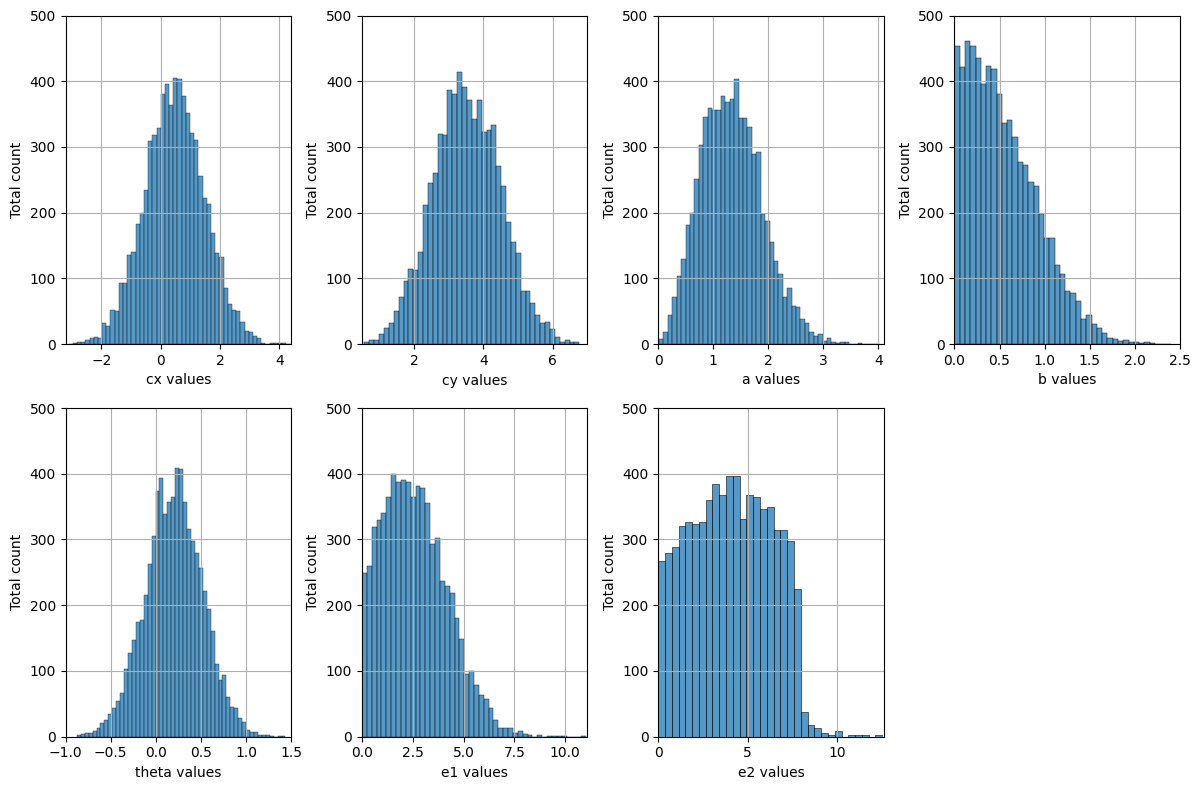

In [9]:
visualize_parameter_distributions(df_parameters, 500)

## Visualizing training data

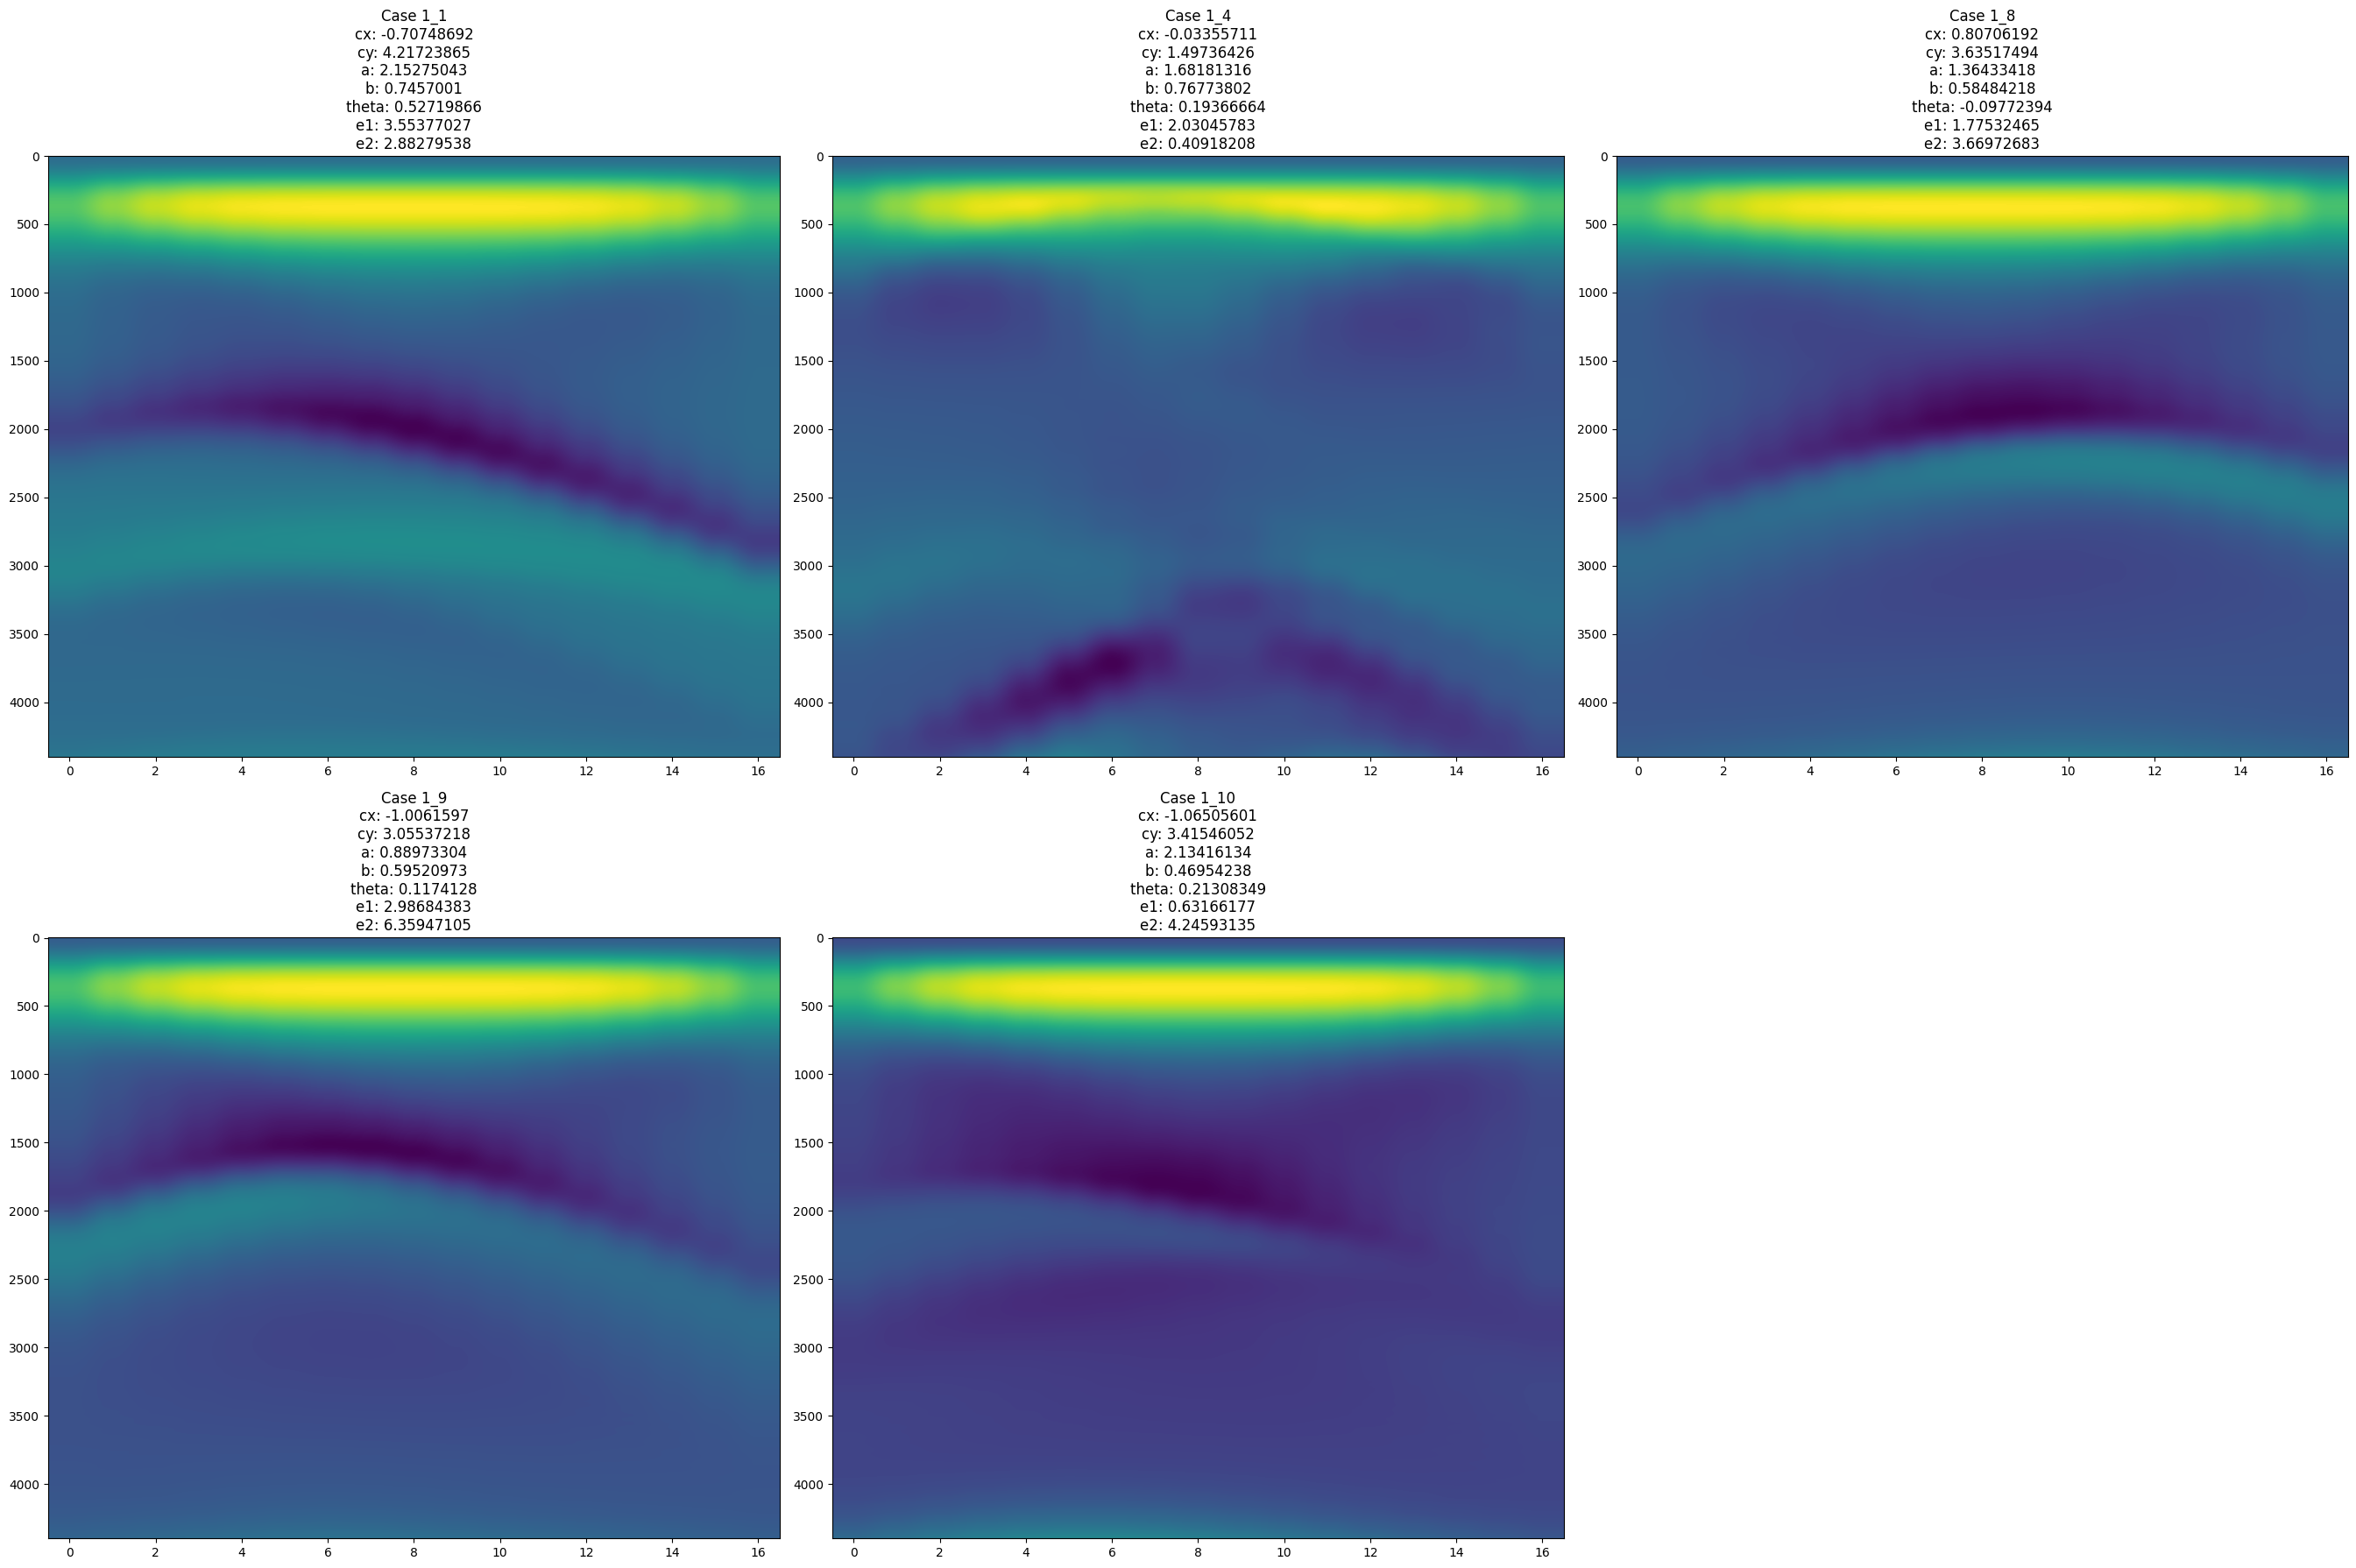

In [10]:
n = 9
idx_viz = []
for i in range(n):
    idx_1 = random.randint(1,5)
    idx_2 = random.randint(1,2000)
    while (idx_1, idx_2) in idx_discard:
        idx_1 = random.randint(1,5)
        idx_2 = random.randint(1,2000)
    idx_viz.append((idx_1,idx_2))

visualize([(1, 1), (1, 4), (1, 8), (1, 9), (1, 10)], df_parameters, cols = 3)

## Preprocessing

In [11]:
pip install iterative-stratification


In [12]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [13]:
X = pd.DataFrame(df_parameters['data_index'])
y = df_parameters.drop(['data_index'], axis=1)

In [14]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle = True, random_state=0)
X.loc[:, 'fold'] = -1
y.loc[:, 'fold'] = -1

In [15]:
for fold_ , (train_, valid_) in enumerate(mskf.split(X=X, y=y)):
    X.loc[valid_, 'fold'] = fold_
    y.loc[valid_, 'fold'] = fold_

------------- FOLD 0 -------------
        count      mean       std       min       50%        max
cx     1409.0  0.497682  1.011916 -3.102034  0.472329   3.982865
cy     1409.0  3.518116  0.975050  0.650975  3.486913   6.178179
a      1409.0  1.348561  0.563976  0.060661  1.329314   3.462639
b      1409.0  0.547716  0.384249  0.001411  0.488191   1.889929
theta  1409.0  0.195132  0.311718 -0.828643  0.182015   1.146249
e1     1409.0  2.652750  1.604187  0.004928  2.523487   9.703464
e2     1409.0  4.054390  2.229325  0.001369  4.111836  10.236425
fold   1409.0  0.000000  0.000000  0.000000  0.000000   0.000000


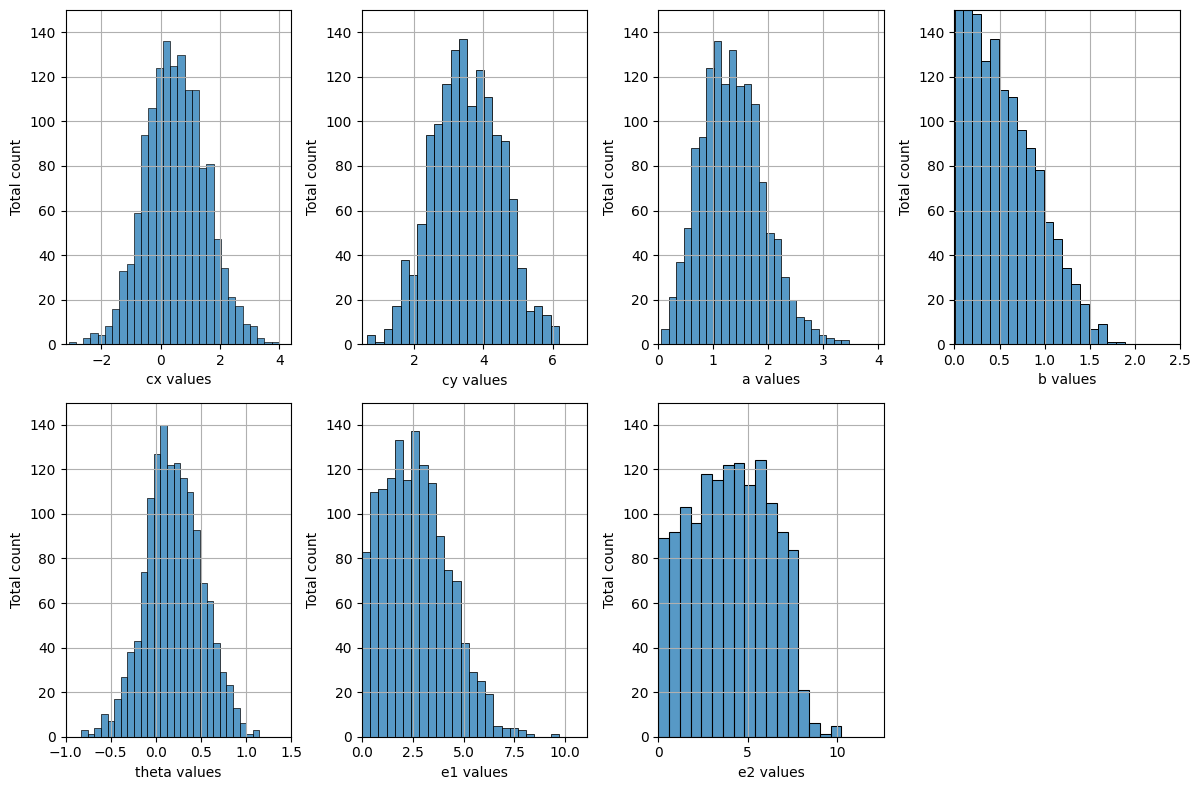

------------- FOLD 1 -------------
        count      mean       std       min       50%        max
cx     1409.0  0.461867  1.001191 -2.694752  0.506650   4.080511
cy     1409.0  3.506020  0.979954  0.760713  3.472484   6.681080
a      1409.0  1.338400  0.569980  0.041495  1.306164   3.851698
b      1409.0  0.550180  0.388639  0.000674  0.485277   2.113519
theta  1409.0  0.197585  0.329186 -0.792064  0.204759   1.373240
e1     1409.0  2.589499  1.582346  0.005511  2.414033   9.153356
e2     1409.0  4.013405  2.200163  0.000887  3.954798  11.566109
fold   1409.0  1.000000  0.000000  1.000000  1.000000   1.000000


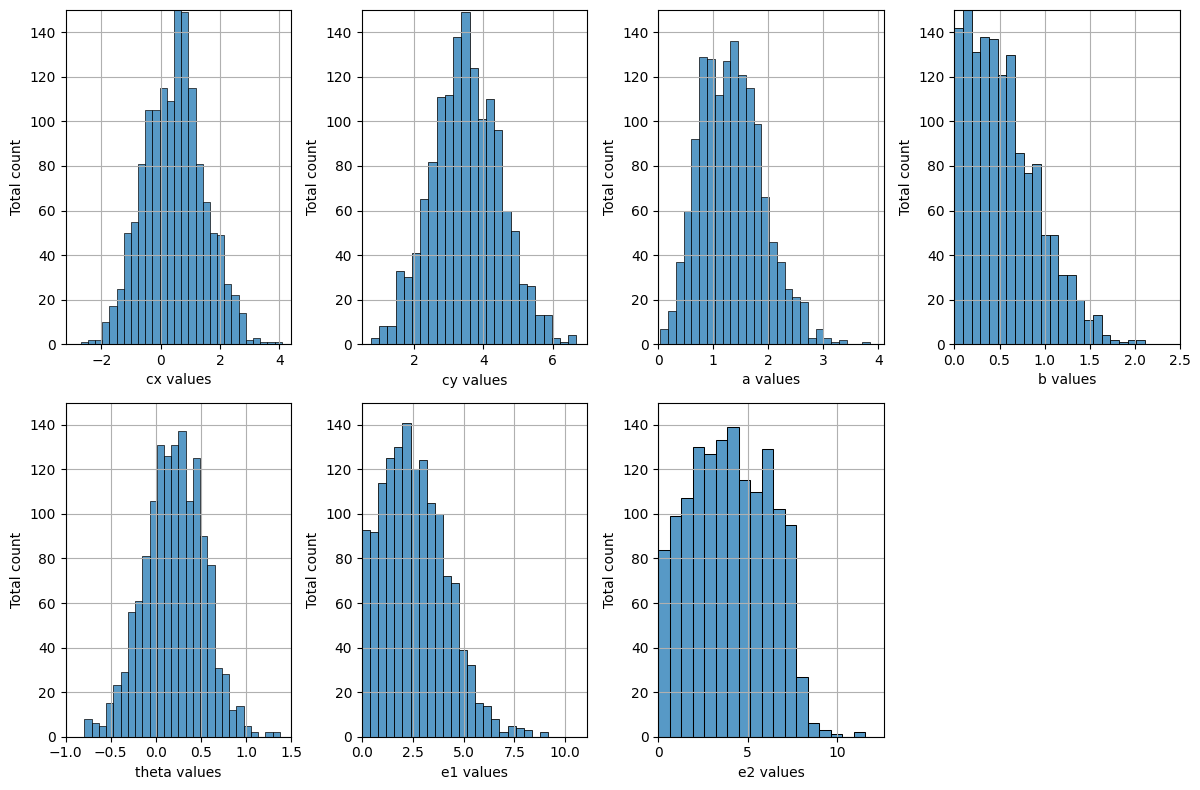

------------- FOLD 2 -------------
        count      mean       std       min       50%        max
cx     1409.0  0.495043  1.018104 -2.835535  0.510157   4.138670
cy     1409.0  3.561732  0.976244  1.065774  3.498646   6.550426
a      1409.0  1.320382  0.567532  0.032099  1.301757   4.032865
b      1409.0  0.521793  0.383801  0.001272  0.432553   2.219840
theta  1409.0  0.195759  0.315937 -0.835219  0.197382   1.435599
e1     1409.0  2.666138  1.601875  0.000006  2.516762  10.031247
e2     1409.0  4.060159  2.258124  0.007117  4.024798  11.511838
fold   1409.0  2.000000  0.000000  2.000000  2.000000   2.000000


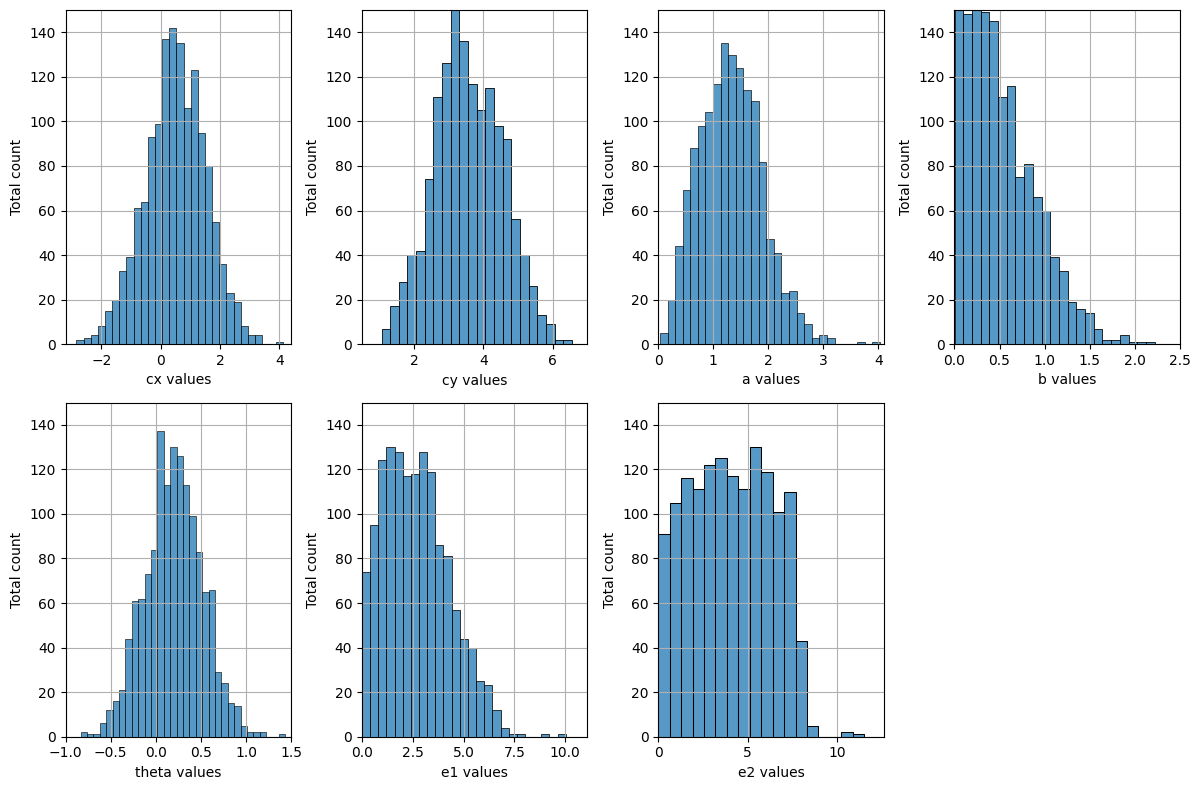

------------- FOLD 3 -------------
        count      mean       std       min       50%        max
cx     1409.0  0.471924  0.996691 -2.808958  0.459624   4.378377
cy     1409.0  3.539515  0.992303  0.572812  3.537027   6.764944
a      1409.0  1.365055  0.561114  0.084304  1.333929   3.642976
b      1409.0  0.554999  0.392196  0.000054  0.485109   2.204865
theta  1409.0  0.201463  0.304723 -0.876184  0.201977   1.141056
e1     1409.0  2.611562  1.544868  0.000099  2.512853   8.093684
e2     1409.0  4.126173  2.280008  0.009448  4.085539  12.385929
fold   1409.0  3.000000  0.000000  3.000000  3.000000   3.000000


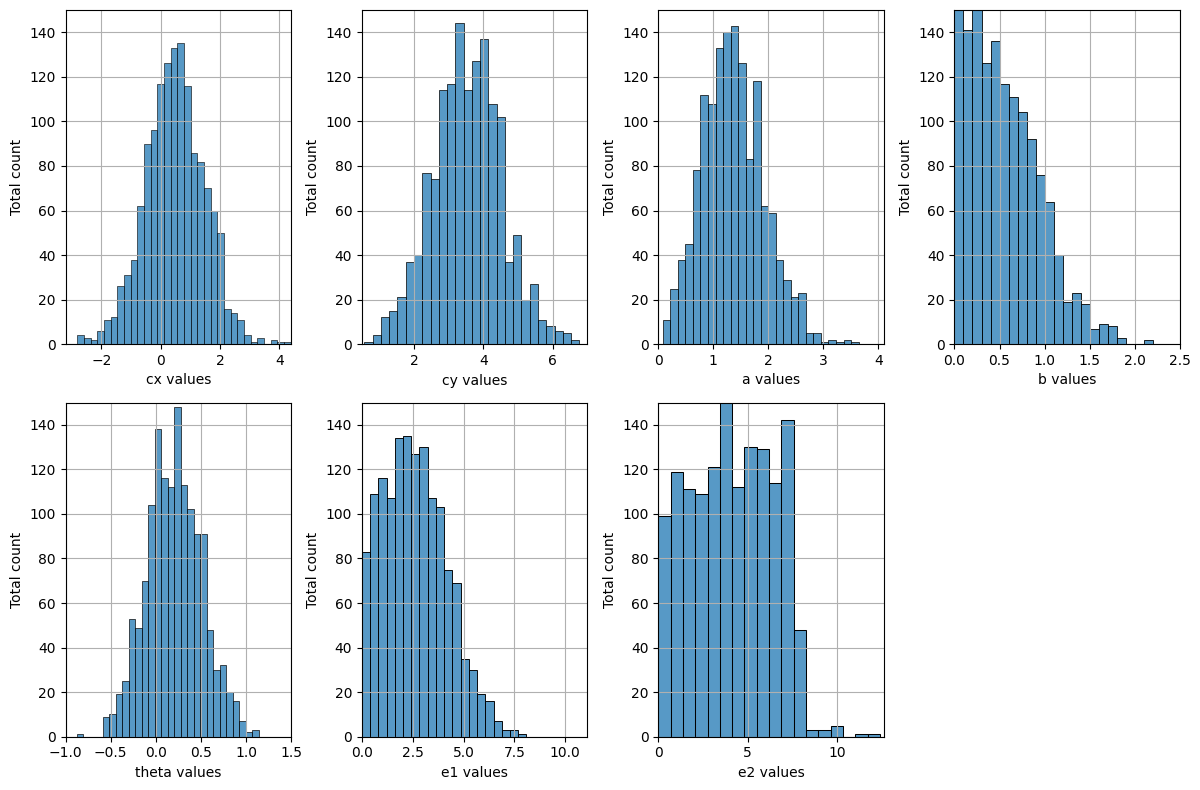

------------- FOLD 4 -------------
        count      mean       std       min       50%        max
cx     1409.0  0.446546  1.015296 -2.364084  0.412590   3.850254
cy     1409.0  3.494216  0.952271  0.752617  3.482253   6.408008
a      1409.0  1.326059  0.547379  0.015081  1.291859   3.120810
b      1409.0  0.555746  0.392661  0.000130  0.492381   2.397364
theta  1409.0  0.209090  0.320576 -0.737332  0.221385   1.229266
e1     1409.0  2.559148  1.605302  0.003543  2.311592  11.031250
e2     1409.0  4.062317  2.212582  0.001778  4.073520  12.517647
fold   1409.0  4.000000  0.000000  4.000000  4.000000   4.000000


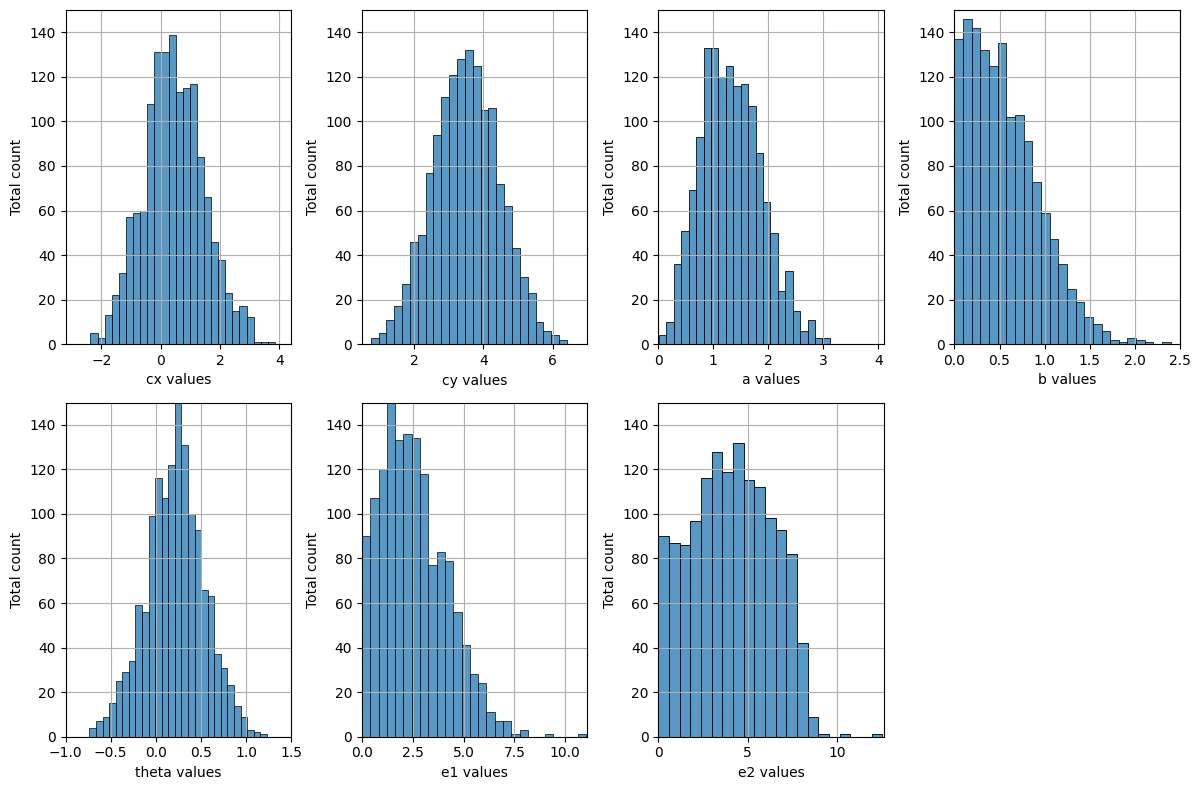

In [17]:
show_distribution = True #Set to true to plot distributions

for i in range(5):
  print(f'------------- FOLD {i} -------------')
  params = y[y['fold'] == i]
  print(params.describe().drop(['25%','75%']).transpose())
  if show_distribution:
    visualize_parameter_distributions(params, 150)

In [18]:
X_train = X[(X['fold'] == 0) | (X['fold'] == 1) | (X['fold'] == 2)]
y_train = y[(y['fold'] == 0) | (y['fold'] == 1) | (y['fold'] == 2)]

X_validation = X[X['fold'] == 3]
y_validation = y[y['fold'] == 3]

X_test = X[X['fold'] == 4]
y_test = y[y['fold'] == 4]

In [19]:
y_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cx,4227.0,0.484864,1.010320,-3.102034,-0.206728,0.494281,1.166377,4.138670
cy,4227.0,3.528623,0.977147,0.650975,2.841524,3.489426,4.232481,6.681080
a,4227.0,1.335781,0.567154,0.032099,0.915487,1.313648,1.702238,4.032865
b,4227.0,0.539896,0.385692,0.000674,0.222945,0.468914,0.790346,2.219840
theta,4227.0,0.196159,0.318960,-0.835219,-0.011469,0.196029,0.415041,1.435599
e1,4227.0,2.636129,1.596138,0.000006,1.388305,2.494477,3.681656,10.031247
e2,4227.0,4.042652,2.228899,0.000887,2.208234,4.040376,5.849037,11.566109
fold,4227.0,1.000000,0.816593,0.000000,0.000000,1.000000,2.000000,2.000000


In [20]:
y_validation.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cx,1409.0,0.471924,0.996691,-2.808958,-0.174671,0.459624,1.123934,4.378377
cy,1409.0,3.539515,0.992303,0.572812,2.856193,3.537027,4.192843,6.764944
a,1409.0,1.365055,0.561114,0.084304,0.959999,1.333929,1.737988,3.642976
b,1409.0,0.554999,0.392196,0.000054,0.234438,0.485109,0.809776,2.204865
theta,1409.0,0.201463,0.304723,-0.876184,-0.003726,0.201977,0.409652,1.141056
e1,1409.0,2.611562,1.544868,0.000099,1.403384,2.512853,3.696406,8.093684
e2,1409.0,4.126173,2.280008,0.009448,2.205827,4.085539,6.074024,12.385929
fold,1409.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [21]:
y_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cx,1409.0,0.446546,1.015296,-2.364084,-0.238529,0.412590,1.110381,3.850254
cy,1409.0,3.494216,0.952271,0.752617,2.837063,3.482253,4.154420,6.408008
a,1409.0,1.326059,0.547379,0.015081,0.926494,1.291859,1.694654,3.120810
b,1409.0,0.555746,0.392661,0.000130,0.242777,0.492381,0.799231,2.397364
theta,1409.0,0.209090,0.320576,-0.737332,-0.000033,0.221385,0.417496,1.229266
e1,1409.0,2.559148,1.605302,0.003543,1.313261,2.311592,3.638873,11.031250
e2,1409.0,4.062317,2.212582,0.001778,2.320091,4.073520,5.827437,12.517647
fold,1409.0,4.000000,0.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [22]:
save_indexes(X_train['data_index'], './utils/train.txt')
save_indexes(X_validation['data_index'], './utils/validation.txt')
save_indexes(X_test['data_index'], './utils/test.txt')